In [58]:
from collections import defaultdict

import h3
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import netCDF4
from preprocessing.config import BOUNDING_BOX, CYNGNSS_FEATURES_HEADER
import glob 
import os
import h3
import csv
import pandas as pd
import h5py
import seaborn as sns

In [18]:
# Water map plot
water_map_filename = f'../data/water/lon_110_160_lat_-50_-10_20000x16000.npy'
water_map = np.load(water_map_filename).astype(bool)
im = np.uint8(water_map * 255)
im = Image.fromarray(im)
im.save('../figures/watermap.png')

In [39]:
# landcover map plot
landcover_f = f'../data/landcover/lon_110_160_lat_-50_-10_18000x14400.npy'
landcover = np.load(landcover_f)
cm = plt.get_cmap('hot')
im = cm(landcover / 210)
im = np.uint8(im * 255)
im = Image.fromarray(im)
im.save('../figures/landcover.png')

In [30]:
# Cygnss before after
def get_bbox_filter_mask(nc):
    min_lon, min_lat, max_lon, max_lat = BOUNDING_BOX
    lon_mask = ((nc['sp_lon'][:, :] >= min_lon) & (nc['sp_lon'][:, :] < max_lon)).flatten()
    lat_mask = ((nc['sp_lat'][:, :] >= min_lat) & (nc['sp_lat'][:, :] < max_lat)).flatten()
    return lon_mask & lat_mask

def get_filter_mask(nc):
    min_lon, min_lat, max_lon, max_lat = BOUNDING_BOX
    flag_include = 1024
    flag_exclude = (2 + 8 + 16 + 128 + 32768 + 65536)

    flag_mask = ((np.bitwise_and(nc['quality_flags'][:, :], flag_include) == flag_include) & (
            np.bitwise_and(nc['quality_flags'][:, :], flag_exclude) == 0)).flatten()

    lon_mask = ((nc['sp_lon'][:, :] >= min_lon) & (nc['sp_lon'][:, :] < max_lon)).flatten()
    lat_mask = ((nc['sp_lat'][:, :] >= min_lat) & (nc['sp_lat'][:, :] < max_lat)).flatten()
    ddm_snr_mask = (nc['ddm_snr'][:, :] >= 0.5).flatten()
    sp_inc_angle_mask = (nc['sp_inc_angle'][:, :] < 65).flatten()
    return lon_mask & lat_mask & flag_mask & ddm_snr_mask & sp_inc_angle_mask

lats = []
lons = []
values = []
for filename in glob.glob(os.path.join('../data/data_cygnss_l1_v3.2/', '*.nc')):
    nc = netCDF4.Dataset(filename)
    bbox_filter_mask = get_bbox_filter_mask(nc)
    values.append(get_filter_mask(nc)[bbox_filter_mask])
    lons.append(nc['sp_lon'][:, :].flatten()[bbox_filter_mask])
    lats.append(nc['sp_lat'][:, :].flatten()[bbox_filter_mask])

pd.DataFrame({'lat': np.concat(lats, axis=0), 'lon': np.concat(lons, axis=0), 'values': np.concat(values, axis=0)}).to_csv('../figures/pre_process/3_days_cygnss_flags.csv', index=False)


In [34]:
# SMAP before after
def get_bbox_filter_mask(smap, suffix):
    min_lon, min_lat, max_lon, max_lat = BOUNDING_BOX
    lon_mask = ((smap[f'longitude{suffix}'][:, :] >= min_lon) & (smap[f'longitude{suffix}'][:, :] < max_lon)).flatten()
    lat_mask = ((smap[f'latitude{suffix}'][:, :] >= min_lat) & (smap[f'latitude{suffix}'][:, :] < max_lat)).flatten()
    return lon_mask & lat_mask

def get_filter_mask(smap, suffix=''):
    flag_exclude = (1 + 2 + 4)
    min_lon, min_lat, max_lon, max_lat = BOUNDING_BOX
    flag_mask = ((np.bitwise_and(smap[f'retrieval_qual_flag{suffix}'][:, :], flag_exclude) == 0)).flatten()

    lon_mask = ((smap[f'longitude{suffix}'][:, :] >= min_lon) & (smap[f'longitude{suffix}'][:, :] < max_lon)).flatten()
    lat_mask = ((smap[f'latitude{suffix}'][:, :] >= min_lat) & (smap[f'latitude{suffix}'][:, :] < max_lat)).flatten()

    return flag_mask & lon_mask & lat_mask

lats = []
lons = []
values = []
for filename in sorted(glob.glob(os.path.join('../data/SPL3SMP_E/', '*.h5'))):
    smap_file = h5py.File(filename)
    for period in ['PM', 'AM']:
        smap = smap_file[f'Soil_Moisture_Retrieval_Data_{period}']
        suffix = '_pm' if period == 'PM' else ''
        bbox_filter_mask = get_bbox_filter_mask(smap, suffix)
        values.append(get_filter_mask(smap, suffix)[bbox_filter_mask])
        lons.append(smap['longitude' + suffix][:, :].flatten()[bbox_filter_mask])
        lats.append(smap['latitude' + suffix][:, :].flatten()[bbox_filter_mask])


pd.DataFrame({'lat': np.concat(lats, axis=0), 'lon': np.concat(lons, axis=0), 'values': np.concat(values, axis=0)}).to_csv('../figures/pre_process/_14_days_smap_flags.csv', index=False)


In [175]:

# SMAP before after flag 1 not excluded
def get_bbox_filter_mask(smap, suffix):
    min_lon, min_lat, max_lon, max_lat = BOUNDING_BOX
    lon_mask = ((smap[f'longitude{suffix}'][:, :] >= min_lon) & (smap[f'longitude{suffix}'][:, :] < max_lon)).flatten()
    lat_mask = ((smap[f'latitude{suffix}'][:, :] >= min_lat) & (smap[f'latitude{suffix}'][:, :] < max_lat)).flatten()
    return lon_mask & lat_mask

def get_filter_mask(smap, suffix=''):
    flag_exclude = (2 + 4)
    min_lon, min_lat, max_lon, max_lat = BOUNDING_BOX
    flag_mask = ((np.bitwise_and(smap[f'retrieval_qual_flag{suffix}'][:, :], flag_exclude) == 0)).flatten()

    lon_mask = ((smap[f'longitude{suffix}'][:, :] >= min_lon) & (smap[f'longitude{suffix}'][:, :] < max_lon)).flatten()
    lat_mask = ((smap[f'latitude{suffix}'][:, :] >= min_lat) & (smap[f'latitude{suffix}'][:, :] < max_lat)).flatten()

    return flag_mask & lon_mask & lat_mask

lats = []
lons = []
values = []
for filename in sorted(glob.glob(os.path.join('../data/SPL3SMP_E/', '*.h5'))):
    smap_file = h5py.File(filename)
    for period in ['PM', 'AM']:
        smap = smap_file[f'Soil_Moisture_Retrieval_Data_{period}']
        suffix = '_pm' if period == 'PM' else ''
        bbox_filter_mask = get_bbox_filter_mask(smap, suffix)
        values.append(get_filter_mask(smap, suffix)[bbox_filter_mask])
        lons.append(smap['longitude' + suffix][:, :].flatten()[bbox_filter_mask])
        lats.append(smap['latitude' + suffix][:, :].flatten()[bbox_filter_mask])


pd.DataFrame({'lat': np.concat(lats, axis=0), 'lon': np.concat(lons, axis=0), 'values': np.concat(values, axis=0)}).to_csv('../figures/pre_process/14_days_smap_flags_(falg 1 not excluded).csv', index=False)


In [49]:
# Boxplot
def get_features(dataset_path):
    data = np.load(dataset_path)
    features = data[:, :data.shape[1] - (17 * 11)]
    return features

columns = CYNGNSS_FEATURES_HEADER.split(',')
# 1st and 15th of each Month considered
features = np.concat([get_features(path) for path in [f'../data/train_label/2022{i:02d}{j}.npy' for i in range(1, 13) for j in ['01','15']]], axis=0)
df = pd.DataFrame(features, columns=columns[:len(columns) - (17 * 11)])


for column in df.columns:
    plt.figure()
    df.boxplot([column])
    plt.savefig(f'../figures/pre_process/boxblot_features/{column}.png')
    plt.close()


<Figure size 640x480 with 0 Axes>

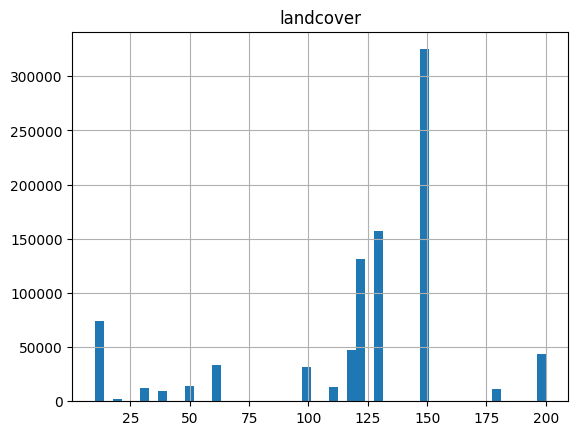

In [56]:
# Landcover hist
plt.figure()
df.hist('landcover', bins=50)
plt.savefig(f'../figures/pre_process/landcover_hist.png')

In [67]:
corr = df.drop(['timestamp_lst', 'rounded_timestamps'], axis=1).corr()
cmap = sns.diverging_palette(5, 250, as_cmap=True)

def magnify():
    return [dict(selector="th",
                 props=[("font-size", "7pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '12pt')])
]

corr.style.background_gradient(cmap, axis=1)\
    .format(precision=3)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_caption("Correlation Matrix")\
    .set_table_styles(magnify()).to_html('../figures/pre_process/corr_matrix.html')

np.abs(corr).style.background_gradient(cmap, axis=1)\
    .format(precision=3)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_caption("Correlation Matrix")\
    .set_table_styles(magnify()).to_html('../figures/pre_process/abs_corr_matrix.html')